In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Przetwarzanie Grafiki i Muzyki - laboratorium nr 9: Operacje „Hit-and-Miss” („Hit-or-Miss”)


  * Bazowa operacja morfologii matematycznej.
  * W notebooku będziemy pracować na elementach strukturalnych, które mają następujące elementy:
    * Piksele obiektu ('1')
    * Piksele tła ('0')
    * Piksele nieokreślone – niebrane pod uwagę ('x')

  * Obraz wejściowy jest przeglądany piksel po pikselu, a następnie, jeśli konfiguracja pikseli sąsiednich jest identyczna jak w elemencie strukturalnym (ang. structural element, w skrócie SE), to jest on ustawiany na wartość '1', w przeciwnym przypadku na '0'.
  * Aby wykryć daną cechę, wyniki kilku SE mogą się sumować/mnożyć.
  
  
## Hit-or-miss - w skrócie

  * Przykładamy środek obiektu strukturalnego do każdego piksela obrazka i jeśli pasuje on do sąsiedztwa danego piksela, to zamieniam piksel na biały, a jeśli nie to na czarny.

## Zadanie 1 (2 punkty)
  * Proszę dokonac binaryzacji obrazu LENA_512 algorytmem Otsu.
  * Proszę wykonać operację Hit-or-miss przy pomocy danego elementu strukturalnego:


$$
\begin{bmatrix} 
1 & 1 & 1 \\
1 & x & 1 \\
1 & 1 & 1 \\
\end{bmatrix} 
$$

Hint: Aby wykonać to zadanie, proszę spojrzeć na dokumentację metody morphologyEx(...) z pakietu OpenCV.

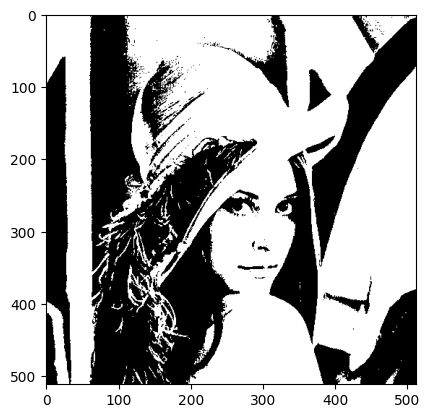

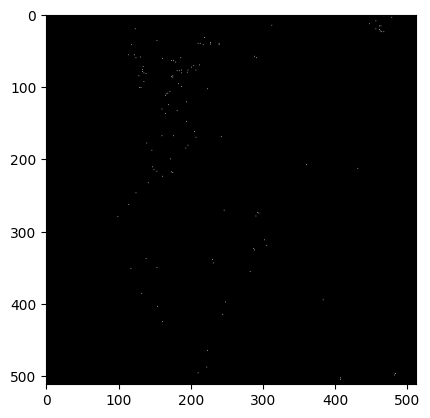

In [30]:
lena = cv2.cvtColor(cv2.imread('./img/LENA_512.jpg'), cv2.COLOR_BGR2YCrCb)

lena_binary = cv2.threshold(lena[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
kernel = np.array([[1,1,1],[1,-1,1],[1,1,1]], dtype=np.int8)
res = cv2.morphologyEx(lena_binary, cv2.MORPH_HITMISS, kernel)

plt.figure()
plt.imshow(lena_binary, cmap='grey')
plt.figure()
plt.imshow(res, cmap='grey')

## Operacja pogrubiania – wypukły kształt (convex hull)

Naszym celem jest znalezienie wypukłej otoczki obiektów.

  * Używanych jest 8 SE:
    * 2 wzorcowe:

$$
\begin{bmatrix} 
1 & 1 & x \\
1 & 0 & x \\
1 & x & 0 \\
\end{bmatrix} 
$$

oraz

$$
\begin{bmatrix} 
x & 1 & 1 \\
x & 0 & 1 \\
0 & x & 1
\end{bmatrix} 
$$
  * Po 3 SE z każdego wzorcowego obrócone o 90, 180, 270 stopni.

  * Procedura iteracyjna: po osiągnięciu zbieżności kolejne iteracje nie zmieniają wyniku (procedura zatrzymuje się sama)

## Zadanie 2 (4 punkty)

Proszę zbudować otoczkę wypukłą elementów na https://raw.githubusercontent.com/przem85/PGiM/master/img/convex.png. Proszę pokazać efekty skończonej procedury.

HINT: Aby zbudować otoczkę wypukłą na obiekcie, musimy najpierw znaleźć jego kształt!

10


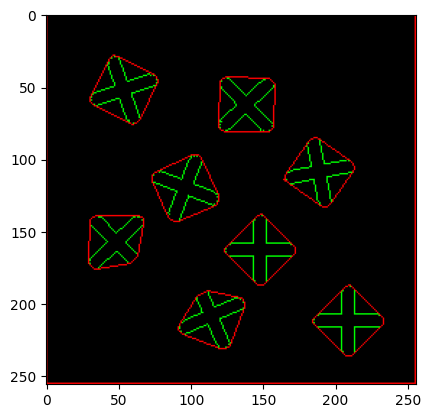

In [20]:
image = cv2.imread('./img/convex.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
contours, hierarchy = cv2.findContours(~image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

hull = []
for cnt in contours:
    hull.append(cv2.convexHull(cnt))

drawing = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
 
for i in range(len(contours)):
    color_contours = (0, 255, 0)
    color = (255, 0, 0)
    cv2.drawContours(drawing, contours, i, color_contours, 1, 8, hierarchy)
    cv2.drawContours(drawing, hull, i, color, 1, 8)
    
plt.imshow(drawing)

# Operacje pocieniania – znajdowanie szkieletu obiektu

  * Naszym celem jest znalezienie szkieletu obiektu – linii reprezentujących obiekt.

  * iteracyjne zmniejszanie obiektów – 8 SE powstałych z obrotów 2 SE:

$$
\begin{bmatrix} 
1 & 1 & x \\
1 & 0 & x \\
1 & x & 0 \\
\end{bmatrix} 
$$

oraz

$$
\begin{bmatrix} 
x & 1 & 1 \\
x & 0 & 1 \\
0 & x & 1
\end{bmatrix} 
$$

# Zadanie 3 (4 punkty)
Proszę zbudować szkielet powyższą metodą na zbinaryzowanych (algorytmem 0tsu) obrazkach (Uwaga: Obrazki poniżej nie są binarne). Proszę wykonać zadanie na dwóch wybranych obrazkach:

  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template1.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template2.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template3.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template4.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template5.png.
  * https://raw.githubusercontent.com/przem85/PGiM/master/img/template6.png.

Proszę pokazać efekty z kilku iteracji.

HINT: Proszę rzucić okiem na ten blog http://opencvpython.blogspot.com/2012/05/skeletonization-using-opencv-python.html

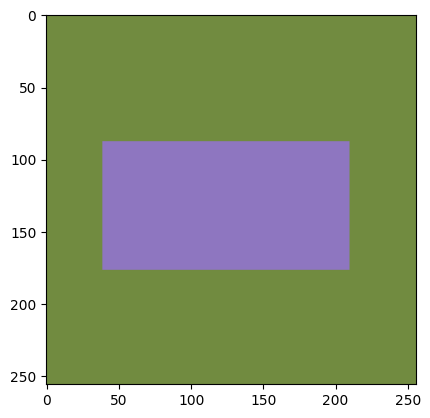

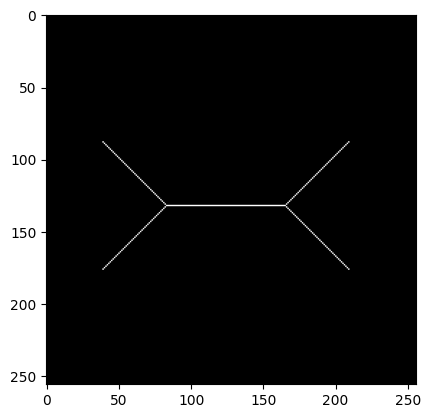

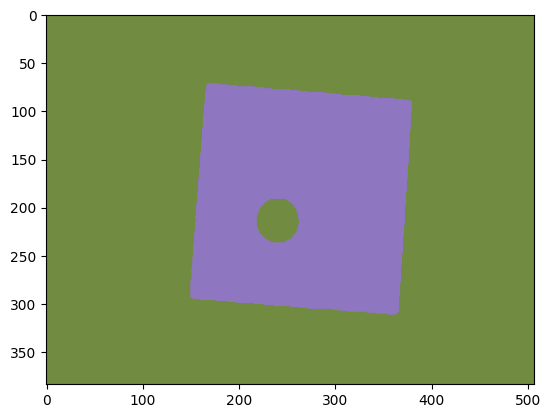

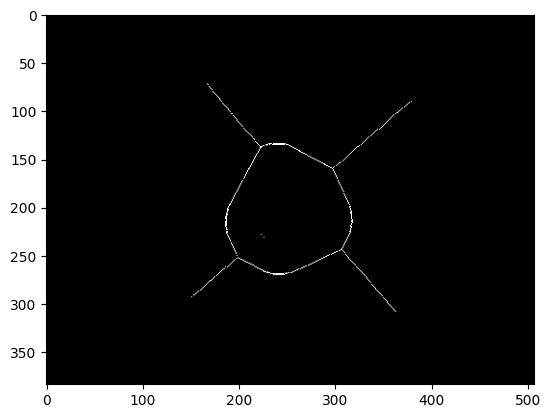

In [29]:
def skeletonize(img):
    img = cv2.threshold(img[:,:,0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    finished = False
    
    plt.figure()
    while not finished:
        eroded = cv2.erode(img, element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
    
        zeros = size - cv2.countNonZero(img)
        if zeros == size:
            finished = True
    
    plt.imshow(skel, cmap='gray')
    
    
img1 = cv2.cvtColor(cv2.imread('./img/template1.png'), cv2.COLOR_BGR2YCrCb)
plt.figure()
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2YCrCb))
skeletonize(img1)

img2 = cv2.cvtColor(cv2.imread('./img/template2.png'), cv2.COLOR_BGR2YCrCb)
plt.figure()
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2YCrCb))
skeletonize(img2)